In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def AofT(time,T, ai, taui):
    return ai*np.exp(-time/taui)/(1.+np.exp(-T/(2*taui)))

In [3]:
from SimPEG import *
from simpegem1d.Waveform import CausalConv
import sys
sys.path.append("./DoubleLog/")
from plotting import mapDat
import cPickle as pickle

In [4]:
milligan = pickle.load(open("milligan.p"))

In [5]:
DAT = milligan['DAT']
Header = milligan['header']
time_vtem_mus = np.r_[99,120,141,167,198,234,281,339,406,484,573,682,818,974,1151,1370,1641,1953,2307,2745,3286,3911,4620,5495,6578,7828,9245]
time = time_vtem_mus[4:]*1e-6
obsdata = DAT[:,13:13+27]
xyz = np.c_[DAT[:,0], DAT[:,1], DAT[:,3]]
line = milligan['Line']

In [6]:
linenum = 6
Line = np.unique(line)
indline = line == Line[linenum]
print Line[linenum]
# plt.plot(xyz[:,0], xyz[:,1], '.')
# plt.plot(xyz[indline,0], xyz[indline,1], 'r.')

560


In [7]:
obs_line = obsdata[indline,4:][::10,:]
xyz_line = xyz[indline,:][::10,:]

In [8]:
class LinearSurvey(Survey.BaseSurvey):
    nD = None
    xyz = None
    uncert = None
    def __init__(self, time, xyz,**kwargs): 
        self.time = time        
        self.xyz = xyz
        self.ntime = time.size
        self.ntx = self.xyz.shape[0]
        self.nD = self.ntime*self.ntx
                
    def projectFields(self, u):
        return u
    
    def setUncertainty(self, dobs, perc=0.1, floor=0.):
        self.uncert = np.zeros((self.ntime, self.ntx))
        self.dobs = dobs        
        dobs = dobs.reshape((self.ntime, self.ntx), order='F')
        for itx in range(self.ntx):
            ipind = dobs[:,itx]<0.
            if (ipind).sum() > 3:
                ip = dobs[ipind,itx]
                self.uncert[:,itx] = perc*abs(dobs[:,itx]) + abs(ip).max()
            else:
                self.uncert[:,itx] = perc*abs(dobs[:,itx])+floor
        self.uncert = Utils.mkvc(self.uncert)

        return self.uncert

class LinearProblem(Problem.BaseProblem):

    surveyPair = LinearSurvey
    tau = None
    
    def __init__(self, mesh,**kwargs):
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        self.setTau()
        
    #TODO: make general (not it works for db/dt)
    def getG(self, currentderiv, timeconv, t0=0.):    
        dt = timeconv[1]-timeconv[0]
        ntime = time_conv.size
        meshtime = Mesh.TensorMesh([dt*np.ones(ntime)], x0=[-dt/2.])
        P = meshtime.getInterpolationMat(time+t0, 'CC')        
        self.G = np.zeros((self.survey.ntime, self.ntau))
        for j in range(self.ntau):
            self.G[:,j] = P*(CausalConv(1./self.tau[j]*np.exp(-time_conv/self.tau[j]), -currentderiv, time_conv))    
            
    def setTau(self, minlogtau=-5, maxlogtau=-2, ntau = 81):
        self.tau = np.logspace(minlogtau, maxlogtau, ntau)
        self.ntau = ntau
        
    def fields(self, m, u=None):
        m = m.reshape((self.ntau, self.survey.ntx), order='F')
        pred = self.G.dot(m)
        return Utils.mkvc(pred)

    def Jvec(self, m, v, u=None):
        v = v.reshape((self.ntau, self.survey.ntx), order='F')
        jvec = self.G.dot(v)   
        return Utils.mkvc(jvec)

    def Jtvec(self, m, v, u=None):
        v = v.reshape((self.survey.ntime, self.survey.ntx), order='F')
        jtvec = self.G.T.dot(v)
        return Utils.mkvc(jtvec)


In [9]:
Regularization.BaseRegularization

SimPEG.Regularization.BaseRegularization

In [10]:
meshline = Mesh.TensorMesh([2])
Gx = meshline.cellGradx

In [11]:
Gx.todense()

matrix([[ 0.,  0.],
        [-2.,  2.],
        [ 0.,  0.]])

# Simple exponential basis


$$ \mathbf{A}\mathbf{\alpha} = \mathbf{d}$$

In [12]:
tind = 12
# time = np.load('./exampledata/timevtem.npy')[4:]
# obs = np.load('./exampledata/souding.npy')[4:]
wave = np.loadtxt('/Users/sgkang/Dropbox/Shared/SeogiDikun/Milligan/Data/7042_106_wform.xyz', skiprows=7)
M = 81
tau = np.logspace(-5, -2, M)

In [13]:
twave = (np.arange(10000)+1)*1e-5
indstart = 4439
indend = 6000
t0_wave = twave[indstart:indend].min()
time_conv= twave[indstart:indend]-t0_wave

In [14]:
currentderiv = wave[indstart:indend]
currentderiv[time_conv>4.4e-3] = 0.
current = CausalConv(wave[indstart:indend], np.ones_like(wave[indstart:indend]), time_conv)

(-4.5, 4.5)

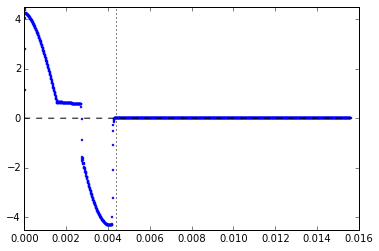

In [15]:
# figsize(6, 4)

plt.plot(time_conv, wave[indstart:indend], 'b.', lw=2, ms=4)
plt.plot(time_conv, wave[indstart:indend]*0., 'k--')
plt.plot(np.r_[4.4000000e-03, 4.4000000e-03], np.r_[-4.5, 4.5], 'k:')
plt.ylim(-4.5, 4.5)
# plt.xlim(-2e-4, 5.5e-3)

(0, 1.0)

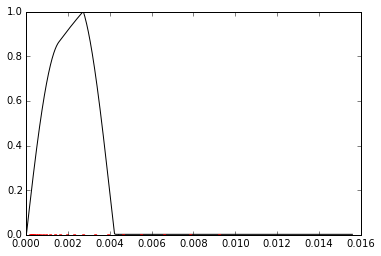

In [16]:
figsize(6, 4)
plt.plot(time_conv, current/current.max(), 'k-')
# plt.plot(time_conv, wave[indstart:indend]*0., 'k--')
plt.plot(np.r_[4.4000000e-03, 4.4000000e-03], np.r_[1e-6, 1e-2], 'k:')
plt.plot(time, np.zeros_like(time), 'r.')
plt.ylim(0, 1.)

In [17]:
from SimPEG import Mesh
from simpegem1d.Waveform import SineFun, SineFunDeriv, CausalConv
dt = 1e-5
t0 = 4.4e-03
ntime = time_conv.size
meshtime = Mesh.TensorMesh([dt*np.ones(ntime)], x0=[-dt/2.])
P = meshtime.getInterpolationMat(time+t0, 'CC')
# time_conv = meshtime.gridN
# currentderiv = SineFunDeriv(time_conv, t0)
# current = SineFun(time_conv, t0)

In [18]:
temp = np.exp(-time_conv/1e-2)/1e-2
out = CausalConv(temp, currentderiv, time_conv)
# plt.plot(time_conv, currentderiv)

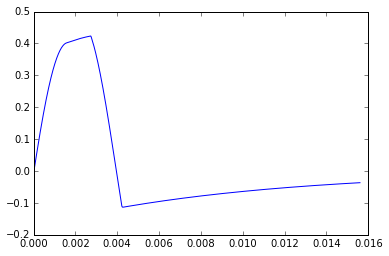

In [19]:
plt.plot(time_conv, out)

In [20]:
time_conv.min(), time_conv.max()

(0.0, 0.015600000000000003)

In [21]:
P.shape

(23, 1561)

In [22]:
# N = time.size
# A = np.zeros((N, M))
# for j in range(M):
#     A[:,j] = P*(CausalConv(1./tau[j]*np.exp(-time_conv/tau[j]), -currentderiv, time_conv))

In [23]:
meshline = Mesh.TensorMesh([xyz_line.shape[0]])
prob = LinearProblem(meshline)
survey = LinearSurvey(time, xyz_line)
prob.pair(survey)
prob.getG(currentderiv, time_conv, t0=4.4e-3)
uncert = survey.setUncertainty(obs_line.flatten(), perc=0.03, floor=1e-4)

In [24]:
mtrue = np.zeros(prob.ntau)
np.random.seed(1)
inds = np.random.random_integers(0, 41, size=5)
mtrue[inds] = np.r_[0.1, 2, 1, 4, 5]
m0 = (np.repeat(mtrue.reshape([1,-1]), survey.ntx, axis=0)).flatten()

In [25]:
from SimPEG import Maps

In [26]:
weightone = np.sqrt(np.diag(np.dot(prob.G.T, prob.G)))

weight = (np.repeat(weightone.reshape([1,-1]), survey.ntx, axis=0)).flatten()
meshreg = Mesh.TensorMesh([weight.size])
wmap = Maps.Weighting(meshreg, weights=weight)


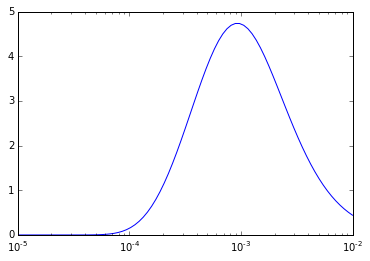

In [27]:
plt.semilogx(prob.tau, weightone)

In [28]:
print uncert.shape
print survey.dobs.shape

(2691,)
(2691,)


In [29]:
from SimPEG.Regularization import BaseRegularization as BaseRegularization
class SmoothAEMRegularization(BaseRegularization):    
    xyz_line = None
    ntau = 81
    alpha_s = 1e0
    alpha_x = 1e0
    def __init__(self, mesh, mapping=None, **kwargs):
        BaseRegularization.__init__(self, mesh, mapping=mapping, **kwargs)
        
    @property
    def W(self):
        """Regularization matrix W"""
        if getattr(self, '_W', None) is None:
            ntx = self.xyz_line.shape[0]
            meshline = Mesh.TensorMesh([ntx])
            Gx = meshline.cellGradx
            Wx = np.sqrt(self.alpha_x)*sp.kron(Gx, Utils.speye(self.ntau))
            Ws = np.sqrt(self.alpha_s)*Utils.speye(self.ntau*ntx)
            wlist = (Wx, Ws)
            self._W = sp.vstack(wlist)            
        return self._W


In [30]:
meshline = Mesh.TensorMesh([survey.ntx])

In [31]:
meshline.nF*prob.ntau

9558

In [32]:
# test = reg.W*Utils.mkvc(mrec)
# test = test.reshape((prob.ntau, meshline.nF), order='F')
# itau = 11
# plt.plot(meshline.vectorCCx, mrec[itau,:])
# plt.plot(meshline.vectorNx, test[itau,:])

In [33]:
# reg = Regularization.BaseRegularization(meshreg, mapping=wmap)
# reg = Regularization.BaseRegularization(meshreg)
reg = SmoothAEMRegularization(meshreg, mapping=wmap)
reg.xyz_line = xyz_line
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(uncert)
opt = Optimization.ProjectedGNCG(maxIter=200)
# opt = Optimization.InexactGaussNewton(maxIter=20)
opt.lower = 1e-20
# opt.upper = 1e-10
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e-12)
beta = Directives.BetaSchedule()
beta.coolingFactor = 1
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target, betaest])
opt.tolG = 1e-10
opt.tolG = 1e-10
m0 = np.ones_like(weight)*1e-10
reg.mref = np.zeros_like(m0)
mrec = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.16e-09  7.16e+05  2.58e-16  7.16e+05    1.26e+07      0              
   1  2.16e-09  3.77e+05  5.21e-01  3.77e+05    8.35e+05      0              
   2  2.16e-09  1.12e+05  2.47e+01  1.12e+05    5.20e+05      0              
   3  2.16e-09  1.03e+05  2.93e+01  1.03e+05    5.14e+05      1   Skip BFGS  
   4  2.16e-09  9.89e+04  3.94e+01  9.89e+04    4.27e+05      0   Skip BFGS  
   5  2.16e-09  7.14e+04  4.29e+01  7.14e+04    7.25e+05      0              
   6  2.16e-09  5.45e+04  8.08e+01  5.45e+04    4.87e+05      0              
   7  2.16e-09  4.85e+04  6.61e+01  4.85e+04    5.82e+05      0       

In [34]:
mrec = mrec.reshape((prob.ntau, survey.ntx), order='F')

In [35]:
target.target

1345.5

In [36]:
14*234

3276

In [37]:
pred = prob.fields(mrec)

In [38]:
pred = pred.reshape((survey.ntime, survey.ntx), order='F')
obs = survey.dobs.reshape((survey.ntime, survey.ntx), order='F')
UNCERT = survey.uncert.reshape((survey.ntime, survey.ntx), order='F')

In [39]:

predmap, ticks, ticklabels = mapDat(pred, 1e-3, stretch=3)
obsmap, ticks, ticklabels = mapDat(obs, 1e-3, stretch=3)

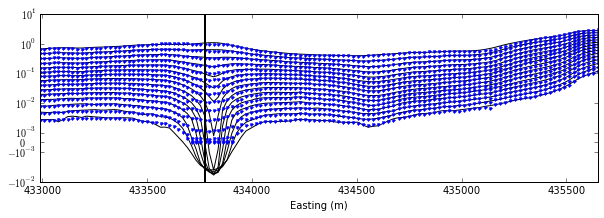

In [45]:
itx = 80
fig = plt.figure(figsize=(10,3))
ax = plt.subplot(111)
for i in range(15):
    ax.plot(xyz_line[:,0], obsmap[i,:], 'k')
    ax.plot(xyz_line[:,0], predmap[i,:], 'b.')
ax.set_xlim(xyz_line[:,0].min(), xyz_line[:,0].max())
ax.set_ylim(ticks.min(), ticks.max())
ax.set_yticks(ticks)
# ax.set_ylim(0., ticks.max())

plt.plot(xyz_line[itx,0]*np.ones(2), np.r_[ticks.min(), ticks.max()],'k-', lw=2)
ax.set_xlabel("Easting (m)")
ax.set_yticklabels(ticklabels)

(432987.40000000002, 435648.90000000002)

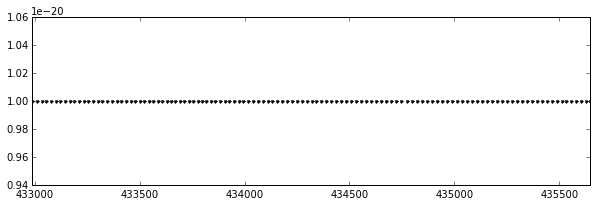

In [46]:
figsize(10, 3)
# for itau in range(9,11,1):
itau = 12
plt.plot(xyz_line[:,0], mrec[itau,:], 'k.')
xlim(xyz_line[:,0].min(), xyz_line[:,0].max()) 
# ylim(1e-1, 1e5)

In [47]:
# for itime in range(time.size):
#     plt.semilogy(xyz_line[:,0], obs[itime,:], 'k-')
#     plt.semilogy(xyz_line[:,0], pred[itime,:], 'b-')
# plt.plot(xyz_line[itx,0]*np.ones(2), np.r_[1e-8, 1e1],'k-', lw=2)
# ylim(1e-6, 2e0)
# xlim(xyz_line[:,0].min(), xyz_line[:,0].max())

(1e-05, 10.0)

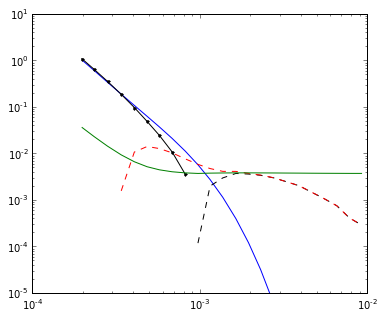

In [48]:
figsize(6,5)
plt.loglog(time, pred[:,itx], 'b-')
plt.loglog(time, obs[:,itx], 'k.-')
plt.loglog(time, -obs[:,itx], 'k--')
plt.loglog(time, -(obs[:,itx]-pred[:,itx]), 'r--')
plt.loglog(time, UNCERT[:,itx], 'g-')
ylim(1e-5, 1e1)

In [78]:

# for itx in range(survey.ntx):
#     plt.semilogx(prob.tau, mrec[:,itx], '.')

(array([ 3.,  3.,  3.,  2.,  3.,  3.,  2.,  3.,  2.,  3.,  3.,  2.,  3.,
         3.,  2.,  3.,  3.,  2.,  3.,  3.,  2.,  3.,  3.,  2.,  3.,  3.,
         3.,  2.,  3.,  3.]),
 array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
        -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9,
        -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ]),
 <a list of 30 Patch objects>)

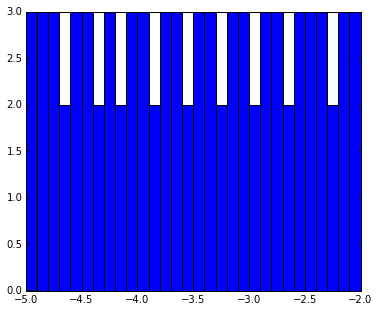

In [63]:
hist(np.log10(tau), bins=30)

In [64]:
# mfund = mrec.copy()
# mip = mrec.copy()
# mfund[mfund<0.] = 0.
# mip[mip>0.] = 0.
# fund = np.dot(A, mfund)

In [65]:
ip = obs-invProb.dpred

ValueError: operands could not be broadcast together with shapes (23,117) (2691,) 

In [66]:
tind = 7
print obs[tind], invProb.dpred[tind], ip[tind]

[ 0.443857  0.443953  0.443771  0.443109  0.442074  0.4411    0.440456
  0.440027  0.439647  0.439574  0.440582  0.44333   0.447609  0.4526
  0.457863  0.463608  0.470069  0.477098  0.484418  0.491948  0.499463
  0.50613   0.511071  0.514366  0.516805  0.518723  0.519728  0.519205
  0.516242  0.509467  0.498179  0.483926  0.470083  0.459212  0.451047
  0.443332  0.434166  0.423259  0.411439  0.399583  0.388087  0.376913
  0.365832  0.35472   0.343813  0.333573  0.324197  0.315442  0.306914
  0.298298  0.289477  0.280716  0.272475  0.264778  0.257113  0.249027
  0.240477  0.231677  0.222961  0.214638  0.206721  0.198995  0.191415
  0.184149  0.177286  0.170866  0.16504   0.159818  0.154926  0.150205
  0.145789  0.141676  0.13752   0.133101  0.128707  0.12483   0.1216
  0.118721  0.115893  0.113036  0.11012   0.107077  0.10389   0.100616
  0.097336  0.094159  0.091193  0.088457  0.085905  0.083534  0.08141
  0.079615  0.078201  0.077048  0.075826  0.074347  0.072866  0.071735
  0.070898 

NameError: name 'ip' is not defined

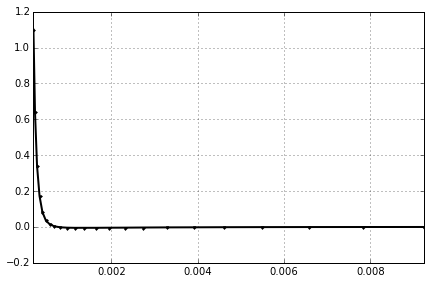

In [72]:
fig = plt.figure(figsize=(7,4.5))
ax = plt.subplot(111)
ax.plot(time, obs, 'k.-', lw=2)
# ax.set_ylim(1e-4, 1e0)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim(time.min(), time.max())
ax.grid(True)

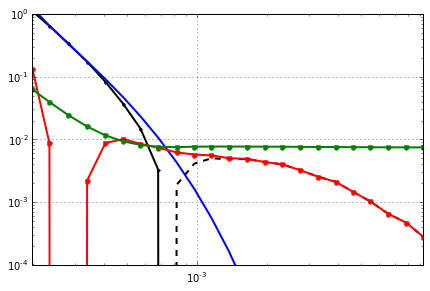

In [73]:
fig = plt.figure(figsize=(7,4.5))
ax = plt.subplot(111)
ax.plot(time, obs, 'k.-', lw=2)
ax.plot(time, -obs, 'k--', lw=2)
ax.plot(time, invProb.dpred, 'b-', lw=2)
ax.plot(time, -ip, 'r.-', lw=2, ms=10)
ax.plot(time, uncert, 'g.-', lw=2, ms=10)
ax.set_ylim(1e-4, 1e0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(time.min(), time.max())
ax.grid(True)

In [74]:
predmap, ticks, tickLabels = mapDat(invProb.dpred,1e-3, stretch=3)    

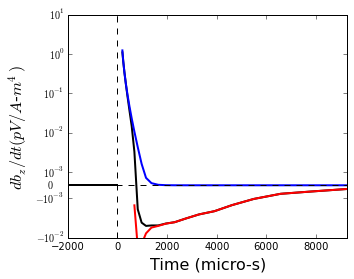

In [75]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

# for i, ind in enumerate(inds):
#     temp, dum, dum = mapDat(mtrue[inds][i]*np.exp(-time/tau[ind]), 1e-5, stretch=2)
#     plt.semilogx(time, temp, 'k', alpha = 0.5)    
outmap, ticks, tickLabels = mapDat(obs,1e-3, stretch=3)    
ax.plot(time*1e6, outmap, 'k', lw=2)
ax.plot(time*1e6, predmap, 'b', lw=2)
ax.plot(time[7:]*1e6, outmap[7:]-predmap[7:], 'r', lw=2)
ax.plot(np.r_[-0.002, 0.]*1e6, np.zeros(2), 'k', lw=2)
ax.plot(np.zeros(2), np.r_[ticks.min(), ticks.max()], 'k--', lw=1)
ax.set_yticks(ticks)
ax.set_yticklabels(tickLabels)
ax.set_ylim(ticks.min(), ticks.max())
ax.plot(np.r_[-0.002, time.max()]*1e6, np.zeros(2), 'k--')
ax.set_xlim(-0.002*1e6, time.max()*1e6)

ax.set_xlabel("Time (micro-s)", fontsize = 16)
ax.set_ylabel("$db_z/dt (pV/A$-$m^4)$ ", fontsize = 16)

# ax.grid(True)

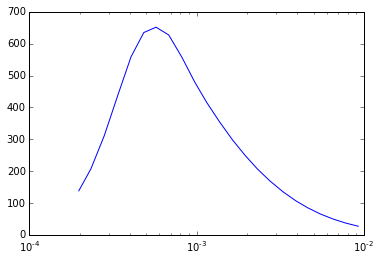

In [76]:
weight_d = np.sqrt(np.diag(np.dot(np.dot(np.diag(1./uncert), A), (np.dot(np.diag(1./uncert), A)).T)))
# weight_d = np.sqrt(np.diag( np.dot(A, A.T)))
plt.semilogx(time, weight_d)